# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.01929692 -0.15405606 -0.00796877  0.26203255] 0 1.0 False {}
state, action, reward, done, info: [-0.02237804  0.04117873 -0.00272812 -0.03315313] 1 1.0 False {}
state, action, reward, done, info: [-0.02155446  0.2363397  -0.00339118 -0.32669556] 1 1.0 False {}
state, action, reward, done, info: [-0.01682767  0.04126619 -0.00992509 -0.03508398] 0 1.0 False {}
state, action, reward, done, info: [-0.01600235  0.23652906 -0.01062677 -0.33088178] 1 1.0 False {}
state, action, reward, done, info: [-0.01127176  0.43180065 -0.01724441 -0.62689685] 1 1.0 False {}
state, action, reward, done, info: [-0.00263575  0.627159   -0.02978234 -0.92496041] 1 1.0 False {}
state, action, reward, done, info: [ 0.00990743  0.82267028 -0.04828155 -1.22685199] 1 1.0 False {}
state, action, reward, done, info: [ 0.02636083  1.01837936 -0.07281859 -1.53426277] 1 1.0 False {}
state, action, reward, done, info: [ 0.04672842  1.21429898 -0.10350385 -1.84875314] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, labelQs, cell, initial_state

In [9]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [37]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs, labelQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    lossQtgt = tf.reduce_mean(tf.square(Qs - targetQs)) # next state, next action and nextQs
    lossQlbl = tf.reduce_mean(tf.square(Qs - labelQs)) # current state, action, and currentQs
    lossQtgt_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                           labels=tf.nn.sigmoid(targetQs)))
    lossQlbl_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
                                                                           labels=tf.nn.sigmoid(labelQs)))
    loss = lossQtgt + lossQlbl + lossQtgt_sigm + lossQlbl_sigm
    return actions_logits, final_state, loss, lossQtgt, lossQlbl, lossQtgt_sigm, lossQlbl_sigm

In [38]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [39]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.labelQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss, self.lossQtgt, self.lossQlbl, self.lossQtgt_sigm, self.lossQlbl_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, labelQs=self.labelQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [40]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [41]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [42]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [43]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [44]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [45]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
memory.buffer[0]

[array([ 0.0068957 ,  0.00404566, -0.02286297,  0.00812363]),
 1,
 array([ 0.00697661,  0.19948791, -0.02270049, -0.29168426]),
 1.0,
 0.0]

In [47]:
# states, rewards, actions

In [ ]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        lossQlbl_batch, lossQlbl_sigm_batch, lossQtgt_batch, lossQtgt_sigm_batch = [], [], [], []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: states, 
                                                   model.initial_state: initial_states[0].reshape([1, -1])})
            labelQs = np.max(actions_logits, axis=1)
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states, 
                                                        model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _, lossQlbl, lossQlbl_sigm, lossQtgt, lossQtgt_sigm = sess.run([model.loss, model.opt, 
                                                                                  model.lossQlbl, 
                                                                                  model.lossQlbl_sigm, 
                                                                                  model.lossQtgt, 
                                                                                  model.lossQtgt_sigm], 
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs,
                                                         model.labelQs: labelQs,
                                                         model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            lossQlbl_batch.append(lossQlbl)
            lossQlbl_sigm_batch.append(lossQlbl_sigm)
            lossQtgt_batch.append(lossQtgt)
            lossQtgt_sigm_batch.append(lossQtgt_sigm)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'meanLossQlbl: {:.4f}'.format(np.mean(lossQlbl_batch)),
              'meanLossQlbl_sigm: {:.4f}'.format(np.mean(lossQlbl_sigm_batch)),
              'meanLossQtgt: {:.4f}'.format(np.mean(lossQtgt_batch)),
              'meanLossQtgt_sigm: {:.4f}'.format(np.mean(lossQtgt_sigm_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model4.ckpt')

Episode: 0 meanReward: 13.0000 meanLoss: 2.4191 meanLossQlbl: 0.0857 meanLossQlbl_sigm: 0.6443 meanLossQtgt: 1.1021 meanLossQtgt_sigm: 0.5870 ExploreP: 0.9987
Episode: 1 meanReward: 16.0000 meanLoss: 2.4825 meanLossQlbl: 0.0473 meanLossQlbl_sigm: 0.2381 meanLossQtgt: 1.9933 meanLossQtgt_sigm: 0.2039 ExploreP: 0.9968
Episode: 2 meanReward: 19.3333 meanLoss: 4.9990 meanLossQlbl: 1.2001 meanLossQlbl_sigm: 0.1493 meanLossQtgt: 3.4026 meanLossQtgt_sigm: 0.2469 ExploreP: 0.9943
Episode: 3 meanReward: 18.2500 meanLoss: 8.7723 meanLossQlbl: 2.6923 meanLossQlbl_sigm: 0.2559 meanLossQtgt: 5.4928 meanLossQtgt_sigm: 0.3314 ExploreP: 0.9928
Episode: 4 meanReward: 18.2000 meanLoss: 5.2933 meanLossQlbl: 0.1563 meanLossQlbl_sigm: 0.0116 meanLossQtgt: 4.9729 meanLossQtgt_sigm: 0.1524 ExploreP: 0.9910
Episode: 5 meanReward: 16.8333 meanLoss: 6.4541 meanLossQlbl: 0.1934 meanLossQlbl_sigm: 0.0003 meanLossQtgt: 6.0901 meanLossQtgt_sigm: 0.1701 ExploreP: 0.9901
Episode: 6 meanReward: 17.4286 meanLoss: 6.008

Episode: 51 meanReward: 21.5312 meanLoss: 70.3398 meanLossQlbl: 2.3562 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 67.4151 meanLossQtgt_sigm: 0.5686 ExploreP: 0.8981
Episode: 52 meanReward: 21.4375 meanLoss: 57.8995 meanLossQlbl: 3.8054 meanLossQlbl_sigm: 0.0001 meanLossQtgt: 53.6789 meanLossQtgt_sigm: 0.4151 ExploreP: 0.8970
Episode: 53 meanReward: 21.2188 meanLoss: 66.4481 meanLossQlbl: 5.4058 meanLossQlbl_sigm: 0.0001 meanLossQtgt: 60.6123 meanLossQtgt_sigm: 0.4299 ExploreP: 0.8962
Episode: 54 meanReward: 20.8750 meanLoss: 63.5829 meanLossQlbl: 4.1102 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 59.0032 meanLossQtgt_sigm: 0.4695 ExploreP: 0.8946
Episode: 55 meanReward: 20.9062 meanLoss: 61.8647 meanLossQlbl: 2.2045 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 59.2359 meanLossQtgt_sigm: 0.4243 ExploreP: 0.8921
Episode: 56 meanReward: 21.6562 meanLoss: 12.9759 meanLossQlbl: 1.6465 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.2207 meanLossQtgt_sigm: 0.1088 ExploreP: 0.8875
Episode: 57 meanReward: 21.7

Episode: 102 meanReward: 24.1875 meanLoss: 17.9597 meanLossQlbl: 0.8432 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.9601 meanLossQtgt_sigm: 0.1564 ExploreP: 0.8025
Episode: 103 meanReward: 23.2812 meanLoss: 19.8980 meanLossQlbl: 2.2411 meanLossQlbl_sigm: 0.0083 meanLossQtgt: 17.4860 meanLossQtgt_sigm: 0.1626 ExploreP: 0.8011
Episode: 104 meanReward: 23.1250 meanLoss: 534.6590 meanLossQlbl: 268.5401 meanLossQlbl_sigm: 0.5973 meanLossQtgt: 264.8720 meanLossQtgt_sigm: 0.6496 ExploreP: 0.8000
Episode: 105 meanReward: 23.2188 meanLoss: 562.6449 meanLossQlbl: 311.9095 meanLossQlbl_sigm: 0.6474 meanLossQtgt: 249.4172 meanLossQtgt_sigm: 0.6709 ExploreP: 0.7984
Episode: 106 meanReward: 22.3125 meanLoss: 274.7181 meanLossQlbl: 143.6965 meanLossQlbl_sigm: 0.6550 meanLossQtgt: 129.6999 meanLossQtgt_sigm: 0.6668 ExploreP: 0.7957
Episode: 107 meanReward: 22.3125 meanLoss: 30.3212 meanLossQlbl: 1.4376 meanLossQlbl_sigm: 0.0318 meanLossQtgt: 28.5920 meanLossQtgt_sigm: 0.2598 ExploreP: 0.7947
Episode: 1

Episode: 153 meanReward: 38.6562 meanLoss: 210.1166 meanLossQlbl: 5.2735 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 203.9228 meanLossQtgt_sigm: 0.9203 ExploreP: 0.6743
Episode: 154 meanReward: 38.8438 meanLoss: 64.8374 meanLossQlbl: 7.9590 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 56.5380 meanLossQtgt_sigm: 0.3404 ExploreP: 0.6719
Episode: 155 meanReward: 36.7500 meanLoss: 79.9700 meanLossQlbl: 3.1841 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 76.3698 meanLossQtgt_sigm: 0.4162 ExploreP: 0.6698
Episode: 156 meanReward: 36.5625 meanLoss: 31.5129 meanLossQlbl: 4.9022 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 26.4069 meanLossQtgt_sigm: 0.2038 ExploreP: 0.6681
Episode: 157 meanReward: 35.8438 meanLoss: 39.1934 meanLossQlbl: 6.8230 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 32.1444 meanLossQtgt_sigm: 0.2260 ExploreP: 0.6672
Episode: 158 meanReward: 34.5625 meanLoss: 80.4160 meanLossQlbl: 7.8032 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 72.1481 meanLossQtgt_sigm: 0.4647 ExploreP: 0.6655
Episode: 159 meanRew

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

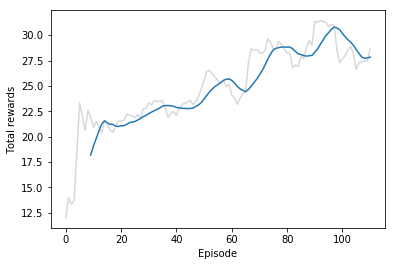

In [182]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

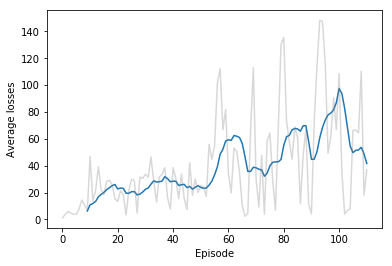

In [183]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.